# Experiments for the retraining note

To be submitted to UAI.
This notebook is modelled on the Wine Quality one.

## 1 Testing exchangeability

First we just read the dataset.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# The key parameters: the 3 below plus Ncal (at the end)
rg = np.random.default_rng(0)     # key parameter; setting the seed for reproducibility [default 0]
Jrate = 0.01  # the jumping rate; in the book: 0.001; canonical: 0.01
K = 3  # the number of folds
SL = 4  # the version of the dataset

# reading the data
if SL==1:
  columns = (1,2,3,4,5,6)
  dataset = np.loadtxt("C:/DnB/Work/R/Papers/OCM/CD/Python/StenaLine/SL_1.csv",
    skiprows=1, delimiter=',', usecols=columns)
elif SL==2:
  columns = (1,2,3,4,5,6)
  dataset = np.loadtxt("C:/DnB/Work/R/Papers/OCM/CD/Python/StenaLine/SL_2.csv",
    skiprows=1, delimiter=',', usecols=columns)
elif SL==3:
  columns = (2,3,4,5)
  dataset = np.loadtxt("C:/DnB/Work/R/Papers/OCM/CD/Python/StenaLine/SL_3.csv",
    skiprows=1, delimiter=',', usecols=columns)
elif SL==4:
  columns = (2,3,4,5,6,7)  # includes GOKI (5) and KIGO (6)
  # columns = (2,3,4,7)   # includes weekday (3)
  # columns = (2,4,7)   # based only on D2D
  # columns = (2,3,7)   # based only on the weekday
  # columns = (2,2,7)   # based only on the week (silly)
  dataset = np.loadtxt("C:/DnB/Work/R/Papers/OCM/CD/Python/StenaLine/SL_4.csv",
    skiprows=1, delimiter=',', usecols=columns)
elif SL==5:  ## IIDisation of the SL_4 dataset
  columns = (2,4,7)   # based only on D2D, with a spare column for IIDisation
  dataset_raw = np.loadtxt("C:/DnB/Work/R/Papers/OCM/CD/Python/StenaLine/SL_4.csv",
    skiprows=1, delimiter=',', usecols=columns)
else:
  print("No such dataset")
last = len(columns)-1  # the index of the label variable
N = dataset.shape[0]  # the total size of the dataset

if SL==5:  ## IIDisation of the SL_4 dataset
  lag = 1
  N = N-lag
  dataset = np.empty((N,4))
  for n in range(N):
    dataset[n,0] = dataset_raw[n+lag,0]
    dataset[n,1] = dataset_raw[n+lag,1]
    dataset[n,2] = dataset_raw[n,2]
    dataset[n,3] = dataset_raw[n+lag,2]

if SL==1:
  N_train = 600         # the size of the training set for SL_1
elif SL==2:
  N_train = 450
elif SL==3:
  N_train = 2400        # default: 2700
elif SL==4 or SL==5:
  N_train = 2400        # default: 2700
else:
  print("No such dataset")
N_test = N - N_train  # the size of the test set

train = np.copy(dataset[0:N_train,:])  # the training set
test = np.copy(dataset[N_train:N,:])   # the test set

rg.shuffle(train)  # shuffling the training set

# Other views of the data:
if SL==1:
  X_train = train[:,1:last]  # matrix of objects
  X_test = test[:,1:last]  # matrix of objects
  y_train = train[:,last]    # vector of labels (real numbers)
  y_test = test[:,last]    # vector of labels (real numbers)
elif SL==2:
  X_train = train[:,2:last]  # matrix of objects
  X_test = test[:,2:last]  # matrix of objects
  y_train = train[:,last]    # vector of labels (real numbers)
  y_test = test[:,last]    # vector of labels (real numbers)
elif SL==3:
  X_train = train[:,1:last]  # matrix of objects
  X_test = test[:,1:last]  # matrix of objects
  y_train = train[:,last]    # vector of labels (real numbers)
  y_test = test[:,last]    # vector of labels (real numbers)
elif SL==4 or SL==5:
  X_train = train[:,1:last]  # matrix of objects
  X_test = test[:,1:last]  # matrix of objects
  y_train = train[:,last]    # vector of labels (real numbers)
  y_test = test[:,last]    # vector of labels (real numbers)
else:
  print("No such dataset")

fold_size = int(N_train/3)   # N_train is assumed divisible by 3
fold = np.array([0,fold_size,2*fold_size])  # the array of starting positions of different folds
print("The sizes of the training and test sets are:",N_train,N_test)

# The linear calibrator:
def lin_cal(p,a):
  return 1 + a*(p-0.5)

# My family of calibrators:
Ncal = 3  # the number of calibrators; default 2 or 3
def my_cal(p,k):
  if k==0:
    return lin_cal(p,1)
  if k==1:
    return lin_cal(p,-1)
  if k==2:
    return lin_cal(p,0)
  else:
    print("my_cal failure")

The sizes of the training and test sets are: 2400 920


Let us now process the test observations carefully (shuffling each week).

In [2]:
test_week = np.copy(dataset[N_train:N,0])   # the week numbers in the test set
current_week = test_week[0]
first_index = 0
for n in range(1,N_test):
  if test_week[n] != current_week:
    to_shuffle = test[first_index:n]  # current week that needs shuffling
    rg.shuffle(to_shuffle)
    test[first_index:n] = to_shuffle
    current_week = test_week[n]
    first_index = n
  if n == N_test-1:
    to_shuffle = test[first_index:N_test]  # last week, which needs shuffling
    rg.shuffle(to_shuffle)
    test[first_index:N_test] = to_shuffle

The following is a much more careless procedure (shuffling periodically).

In [4]:
from_index = 0
while True:
  to_index = from_index + 50
  # print(to_index)
  if to_index >= N_test:
    to_shuffle = test[from_index:N_test]
    rg.shuffle(to_shuffle)
    # print(to_shuffle.size)
    test[from_index:N_test] = to_shuffle
    break
  else:
    to_shuffle = test[from_index:to_index]
    # print(from_index,to_index,to_shuffle.size)
    rg.shuffle(to_shuffle)
    # print(from_index,to_index,to_shuffle.size)
    test[from_index:to_index] = to_shuffle
    from_index = to_index

### 1.1 Various inductive conformity measures

Let us now use $|y-\hat y|$ (absdiff) or $y-\hat y$ (diff)
for the underlying algorithms that perform best on the full training set.
Running time: around 2-3 secs.

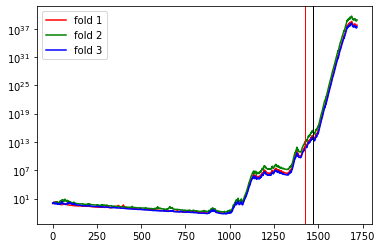

Time elapsed: 2.3279194831848145


In [6]:
predictor = 0  # 0 Least Squares, 1 Ridge Regression, 2 SGD, 3 Lasso, 4 Ilia's Nearest Distance
c_measure = 0  # 0 diff (difference), 1 absdiff (absolute difference), 2 diff for Ilia's Nearest distance

if predictor==0:
  from sklearn.linear_model import LinearRegression
elif predictor==1:
  from sklearn.linear_model import Ridge
elif predictor==2:
  from sklearn.linear_model import SGDRegressor
elif predictor==3:
  from sklearn.linear_model import Lasso
elif predictor==4:
  from sklearn.neighbors import NearestNeighbors
else:
  print("Invalid predictor")

import time   # for timing
start = time.time()

martingales = np.zeros((K,fold_size+N_test))
martingales_size = np.zeros(K)

# Going over all folds:
for kkk in range(K):
  current_fold = np.arange(fold[kkk],fold[kkk]+fold_size)
  calibration = np.copy(train[current_fold])  # calibration set (=current fold)
  N_calibration = calibration.shape[0]   # the size of the calibration set
  rest = np.setdiff1d(np.arange(N_train),current_fold)  # the remaining folds
  train_proper = np.copy(train[rest])  # training set proper
  N_train_proper = train_proper.shape[0]  # the size of the training set proper
  # Other views of the data:
  if SL==1:
    X_calibration = calibration[:,1:last]  # matrix of objects
    X_train_proper = train_proper[:,1:last]  # matrix of objects
    y_calibration = calibration[:,last]    # vector of labels (real numbers)
    y_train_proper = train_proper[:,last]    # vector of labels (real numbers)
  elif SL==2:
    X_calibration = calibration[:,2:last]  # matrix of objects
    X_train_proper = train_proper[:,2:last]  # matrix of objects
    y_calibration = calibration[:,last]    # vector of labels (real numbers)
    y_train_proper = train_proper[:,last]    # vector of labels (real numbers)
  elif SL==3:
    X_calibration = calibration[:,1:last]  # matrix of objects
    X_train_proper = train_proper[:,1:last]  # matrix of objects
    y_calibration = calibration[:,last]    # vector of labels (real numbers)
    y_train_proper = train_proper[:,last]    # vector of labels (real numbers)
  elif SL==4 or SL==5:
    X_calibration = calibration[:,1:last]  # matrix of objects
    X_train_proper = train_proper[:,1:last]  # matrix of objects
    y_calibration = calibration[:,last]    # vector of labels (real numbers)
    y_train_proper = train_proper[:,last]    # vector of labels (real numbers)
  else:
    print("No such dataset here")
  # Normalization
  scaler = StandardScaler()
  scaler.fit(X_train_proper)
  X_train_proper_scaled = scaler.transform(X_train_proper)
  X_calibration_scaled = scaler.transform(X_calibration)
  X_test_scaled = scaler.transform(X_test)

  # Computing the p-values:
  N_runs = N_calibration + N_test  # number of runs

  # p is the p-values
  p = np.zeros(N_runs)    # p initialized

  p[0] = rg.random()

  ## The key part starts.  First, choose predictor and train it on the training set proper.
  if predictor==0: # Least Squares
    model = LinearRegression()
    # model = KNeighborsClassifier(n_neighbors=1, p=1)  # using the Manhattan metric
  elif predictor==1: # Ridge Regression
    model = Ridge()
  elif predictor==2: # Stochastic Gradient Descent
    model = SGDRegressor(random_state=0)
  elif predictor==3:
    model = Lasso()
  elif predictor==4:
    model = NearestNeighbors(n_neighbors=1)
  else:
    print("Failure")
  model.fit(X_train_proper_scaled,y_train_proper)

  ## Evaluating the quality for diff and absdiff:
  if c_measure==0:  # diff
    predictions_calibration = model.predict(X_calibration_scaled)
    predictions_test = model.predict(X_test_scaled)
    conf_scores_calibration = y_calibration - predictions_calibration
    conf_scores_test = y_test - predictions_test
  elif c_measure==1:  # absdiff
    predictions_calibration = model.predict(X_calibration_scaled)
    predictions_test = model.predict(X_test_scaled)
    conf_scores_calibration = np.abs(y_calibration - predictions_calibration)
    conf_scores_test = np.abs(y_test - predictions_test)
  elif c_measure==2:  # only for Ilia's nearest distance
    conf_scores_calibration = np.array(model.kneighbors(X_calibration_scaled))[0,:,0]
    conf_scores_test = np.array(model.kneighbors(X_test_scaled))[0,:,0]
  else:
    print("Failure")

  for n in range(1,N_calibration):  # the first phase (going over the calibration set)
    countG = 0   # the number of alpha's > alpha_n
    countE = 1   # the number of alpha's = alpha_n
    alpha_n = conf_scores_calibration[n]  # (non)conformity score
    for i in range(n):
      alpha_i = conf_scores_calibration[i]  # (non)conformity score
      if alpha_i > alpha_n:
        countG = countG+1
      if alpha_i == alpha_n:
        countE = countE+1
    p[n] = (countG + rg.random() * countE) / (n+1)

  for n in range(N_test):  # the second phase (going over the test set)
    countG = 0   # the number of alpha's > alpha_n
    countE = 1   # the number of alpha's = alpha_n
    alpha_n = conf_scores_test[n]  # (non)conformity score
    for i in range(N_calibration):   # going over the calibration set
      alpha_i = conf_scores_calibration[i]  # (non)conformity score
      if alpha_i > alpha_n:
        countG = countG+1
      if alpha_i == alpha_n:
        countE = countE+1
    for i in range(n):  # going over a beginning of the test set
      alpha_i = conf_scores_test[i]  # (non)conformity score
      if alpha_i > alpha_n:
        countG = countG+1
      if alpha_i == alpha_n:
        countE = countE+1
    p[N_calibration+n] = (countG + rg.random() * countE) / (N_calibration+n+1)

  my_colors = ['r','g','b']

  # Processing the test set
  MartCap = np.zeros((Ncal,N_runs))  # the total capital of martingales in each state
  MartCap[:,0] = 1/Ncal  # the initial distribution is uniform
  for i in range(1,N_runs):
    # Jump mixing starts
    Capital = np.sum(MartCap[:,i-1])
    MartCap[:,i] = (1-Jrate)*MartCap[:,i-1] + (Jrate/Ncal)*Capital
    # Jump mixing ends
    for k in range(Ncal):
      MartCap[k,i] = MartCap[k,i] * my_cal(p[i],k)
  martingale = np.sum(MartCap,axis=0)
  plt.plot(martingale,c=my_colors[kkk],label='fold '+str(kkk+1))
  martingales[kkk,0:martingale.size] = martingale  # for future use
  martingales_size[kkk] = martingale.size

plt.yscale("log")
if SL==1:
  plt.axvline(x=772-2*fold_size,c='k',lw=1)   # lockdown in England
elif SL==2:
  plt.axvline(x=478-2*fold_size,c='k',lw=1)   # lockdown in England
elif SL==3:
  plt.axvline(x=2797-2*fold_size,c='k',lw=1)   # WHO declare pandemic (11 Mar 2020)
elif SL==4 or SL==5:
  plt.axvline(x=3070-2*fold_size,c='k',lw=1)   # WHO declare pandemic (11 Mar 2020)
  plt.axvline(x=3027-2*fold_size,c='r',lw=1)   # Beijing cancels Chinese New Year
else:
  print("No such dataset")
plt.legend(loc='best')
# plt.savefig("SL.pdf", bbox_inches='tight')
plt.show()

# print("Final blue value:", martingale2[N-1])

# finding time elapsed in seconds
end = time.time()
print("Time elapsed:", end - start)

# Sound:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

### 1.2 Nicer pictures

If needed, we can easily redraw the Ville picture (since we remembered the martingales).

No such dataset


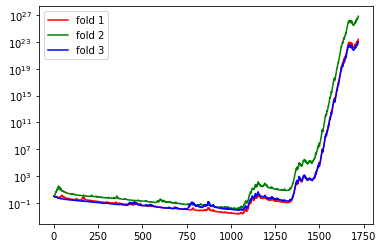

In [19]:
# This code requires the arrays martingales0, martingales 1, and martingales_size
# (and other stuff from the previous cell, such as K)
my_colors = ['r','g','b']
for kkk in range(K):   # going over all folds
  N = int(martingales_size[kkk])  # number of trials
  # N = 1200   # for partial pictures
  plt.plot(martingales[kkk,0:N],c=my_colors[kkk],label='fold '+str(kkk+1))
  ## the change point under microscope:
  # plt.plot(np.arange(1000,N),martingales0[kkk,1000:N],c=my_colors[kkk+3])
  # plt.plot(np.arange(1000,N),martingales1[kkk,1000:N],c=my_colors[kkk],label='fold '+str(kkk+1))
    
predictors = ["LS","RR","SGD","Lasso","IND"]
c_measures = ["diff","absdiff",""]

plt.yscale("log")
if SL==1:
  plt.axvline(x=772-2*fold_size)   # lockdown in England
elif SL==2:
  plt.axvline(x=478-2*fold_size)   # lockdown in England
elif SL==3:
  plt.axvline(x=2797-2*fold_size,c='k',lw=1)   # WHO declare pandemic (11 Mar 2020)
else:
  print("No such dataset")
plt.legend(loc='best')
plt.savefig("SL_"+predictors[predictor]+c_measures[c_measure]+"_Ville.pdf", bbox_inches='tight')
plt.show()

Now let me do the Shiryaev-Roberts picture.

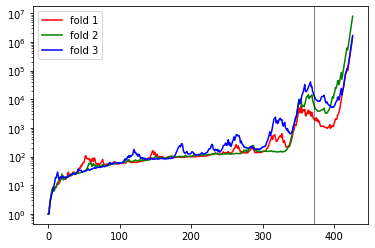

In [93]:
# This code requires the arrays martingales and martingales_size
# (and other stuff from the previous cell, such as K)
my_colors = ['r','g','b']
for kkk in range(K):   # going over all folds
  N = int(martingales_size[kkk])  # number of trials
  SR = np.zeros(N)  # Shiryaev-Roberts array
  for n in range(1,N):  # going over the time
    SR[n] = (martingales[kkk,n]/martingales[kkk,n-1]) * (SR[n-1]+1)
  SR[0] = 1   # for a nicer picture
  plt.plot(SR,c=my_colors[kkk],label='fold '+str(kkk+1))

plt.yscale("log")
plt.axvline(x=772-400, linewidth=0.5, c='k')  # lockdown in England
plt.legend(loc='best')
plt.savefig("SL_"+predictors[predictor]+c_measures[c_measure]+"_SR.pdf", bbox_inches='tight')
plt.show()

Finally, the CUSUM picture.

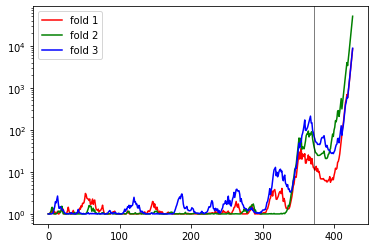

In [94]:
# This code requires the arrays martingales and martingales_size
# (and other stuff from the previous cell, such as K)
my_colors = ['r','g','b']
for kkk in range(K):   # going over all folds
  N = int(martingales_size[kkk])  # number of trials
  CUSUM = np.ones(N)  # CUSUM array
  min_so_far = 1  # min so far initialized
  for n in range(1,N):  # going over the time
    if martingales[kkk,n]<min_so_far:
      min_so_far = martingales[kkk,n]
    CUSUM[n] = martingales[kkk,n] / min_so_far
    # for a nicer picture:
    if CUSUM[n]<1:
      CUSUM[n] = 1
  plt.plot(CUSUM,c=my_colors[kkk],label='fold '+str(kkk+1))

plt.yscale("log")
plt.axvline(x=772-400, linewidth=0.5, c='k')  # lockdown in England
plt.legend(loc='best')
plt.savefig("SL_"+predictors[predictor]+c_measures[c_measure]+"_CUSUM.pdf", bbox_inches='tight')
plt.show()

## 2 Prediction accuracy

Let us first turn the data into a format good for scikit-learn.

In [31]:
from sklearn.preprocessing import StandardScaler

# Normalization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 2.1 The algorithms from CS3920

First the prediction accuracy of K-Nearest Neighbours.

In [61]:
# Training 1-Nearest Neighbour:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
# knn = KNeighborsClassifier(n_neighbors=1, p=1)  # using the Manhattan metric (identical results)
knn.fit(X_train_scaled,y_train)

# Evaluating the quality:
print("Score in scikit-learn:", knn.score(X_test_scaled,y_test))
predictions = knn.predict(X_test_scaled)
print("Accuracy:",np.mean(np.abs(y_test-predictions)))

Score in scikit-learn: 0.02643171806167401
Accuracy: 13.193832599118943


Now let us try Least Squares.

In [59]:
from sklearn.linear_model import LinearRegression
ls = LinearRegression().fit(X_train_scaled,y_train)

# Evaluating the quality:
print("Score in scikit-learn:", ls.score(X_test_scaled,y_test))
predictions = ls.predict(X_test_scaled)
print("MAD:",np.mean(np.abs(y_test-predictions)))

Score in scikit-learn: 0.14811122636355756
MAD: 10.715059699356372


Next Ridge Regression.

In [62]:
from sklearn.linear_model import Ridge
ridge = Ridge().fit(X_train_scaled,y_train)
# ridge = Ridge(alpha=0.1).fit(X_train_scaled,y_train)  # the default (in the line above) is alpha=1

# Evaluating the quality:
print("Score in scikit-learn:", ridge.score(X_test_scaled,y_test))
predictions = ridge.predict(X_test_scaled)
print("Accuracy:",np.mean(np.abs(y_test-predictions)))

Score in scikit-learn: 0.14802915684882512
Accuracy: 10.714250767138552


Now the Lasso.

In [80]:
from sklearn.linear_model import Lasso
lasso = Lasso().fit(X_train_scaled,y_train)

# Evaluating the quality:
print("Score in scikit-learn:", lasso.score(X_test_scaled,y_test))
predictions = lasso.predict(X_test_scaled)
print(lasso)
print("Accuracy:", np.mean(np.abs(y_test-predictions)))
print("Number of non-zero coefficients:", np.sum(lasso.coef_ != 0))
print("The coeeficients:", lasso.coef_)

Score in scikit-learn: 0.1336580328318604
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Accuracy: 10.672711090483382
Number of non-zero coefficients: 1
The coeeficients: [-0.          4.55603094 -0.          0.        ]


Next Nearest Neighbour with the polynomial and RBF kernels.
(This takes 1 sec for the polynomial and 4 secs for RBF.)

In [65]:
import time   # for timing
start = time.time()

def poly_kernel(x,y,d):
  return (1+np.dot(x,y))**d
d = 3 # trying the polynomial kernel of degree d
def poly_dist(x,y): # squared distance
  return poly_kernel(x,x,d) + poly_kernel(y,y,d) - 2*poly_kernel(x,y,d)

def rbf_kernel(x,y,gamma):
  return np.exp(-gamma*np.sum((x-y)**2))
gamma = 10 # the parameter gamma of the rbf kernel
def rbf_dist(x,y): # squared distance
  return rbf_kernel(x,x,gamma) + rbf_kernel(y,y,gamma) - 2*rbf_kernel(x,y,gamma)

# knn = KNeighborsClassifier(n_neighbors=1, metric=rbf_dist)
knn = KNeighborsClassifier(n_neighbors=1, metric=poly_dist)
knn.fit(X_train_scaled,y_train)

# Evaluating the quality:
print("Score in scikit-learn:", knn.score(X_test_scaled,y_test))
predictions = knn.predict(X_test_scaled)
print("Accuracy:",np.mean(np.abs(y_test-predictions)))

# finding time elapsed in seconds
end = time.time()
print("Time elapsed:", end - start)

Score in scikit-learn: 0.030837004405286344
Accuracy: 12.94273127753304
Time elapsed: 3.3799831867218018


Next neural nets (without using the boundedness of the label).

In [66]:
import time   # for timing
start = time.time()

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=0).fit(X_train_scaled, y_train) # 11.6 (2 secs)
# mlp = MLPClassifier(max_iter=1000,random_state=0).fit(X_train_scaled, y_train) # 13.3 (10 secs)
# default max_iter is 200; there was a warning that it's not enough
# mlp = MLPClassifier(hidden_layer_sizes=[10]).fit(X_train_scaled, y_train) # 11.2
# mlp = MLPClassifier(solver='lbfgs',hidden_layer_sizes=[10]).fit(X_train_scaled, y_train) # 
# mlp = MLPClassifier(solver='lbfgs',hidden_layer_sizes=[10],activation='tanh').fit(X_train_scaled, y_train) # 
# the default for the hidden layer sizes is 100; there are warnings about non-convergence
# the options are as in CS3920, Lab 8
mlp.fit(X_train_scaled,y_train)

# Evaluating the quality:
print("Score in scikit-learn:", mlp.score(X_test_scaled,y_test))
predictions = mlp.predict(X_test_scaled)
print("Accuracy:",np.mean(np.abs(y_test-predictions)))

# finding time elapsed in seconds
end = time.time()
print("Time elapsed:", end - start)

C:\Users\uhac013\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Score in scikit-learn: 0.03524229074889868
Accuracy: 11.555066079295154
Time elapsed: 3.0023961067199707


C:\Users\uhac013\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Next linear Support Vector Regression.

In [82]:
import time   # for timing
start = time.time()

from sklearn.svm import LinearSVR
svr = LinearSVR(random_state=0).fit(X_train_scaled, y_train)  # 0.56
# svr = LinearSVR(max_iter=10000,random_state=0).fit(X_train_scaled, y_train)  # 0.56
# the default is max_iter=1000

# Evaluating the quality:
print("Score in scikit-learn:", svr.score(X_test_scaled,y_test))
predictions = svr.predict(X_test_scaled)
print("Accuracy:",np.mean(np.abs(y_test-predictions)))

# finding time elapsed in seconds
end = time.time()
print("Time elapsed:", end - start)

Score in scikit-learn: 0.13309070383865562
Accuracy: 10.497629251102776
Time elapsed: 0.005088090896606445


Next kernel Support Vector Regression.

In [81]:
import time   # for timing
start = time.time()

from sklearn.svm import SVR
svr = SVR().fit(X_train_scaled, y_train)  # 0.50

# Evaluating the quality:
print("Score in scikit-learn:", svr.score(X_test_scaled,y_test))
predictions = svr.predict(X_test_scaled)
print("Accuracy:",np.mean(np.abs(y_test-predictions)))

# finding time elapsed in seconds
end = time.time()
print("Time elapsed:", end - start)

Score in scikit-learn: 0.020055649484843507
Accuracy: 10.62655977829401
Time elapsed: 0.051488637924194336


Now let's try decision trees.

In [74]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
tree.fit(X_train_scaled, y_train)

# Evaluating the quality:
print("Score in scikit-learn:", tree.score(X_test_scaled,y_test))
predictions = tree.predict(X_test_scaled)
print("Accuracy:",np.mean(np.abs(y_test-predictions)))

Score in scikit-learn: -0.16206806485505806
Accuracy: 12.308370044052863


Now we enhance decision trees to the random forest.

In [75]:
from sklearn.ensemble import RandomForestRegressor
# forest = RandomForestRegressor(n_estimators=1000,random_state=0)  # 10,000 is too long
forest = RandomForestRegressor(random_state=0)  # 10.6
# default: n_estimators = 100
# 1000 estimators: 10.6
# 100 estimators: 10.6 (default)
# 10 estimator: 11.1 (this was the defaut before scikit-learn 0.22)
forest.fit(X_train_scaled, y_train)

# Evaluating the quality:
print("Score in scikit-learn:", forest.score(X_test_scaled,y_test))
predictions = forest.predict(X_test_scaled)
print("Accuracy:",np.mean(np.abs(y_test-predictions)))

Score in scikit-learn: 0.0649072123791381
Accuracy: 10.649118942731278


Finally, Gradient Boosting (the other algorithms are for classification).

In [76]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(random_state=0)  # 10.8
# gb = GradientBoostingRegressor(random_state=0,max_depth=1)  # 10.6
# gb = GradientBoostingRegressor(random_state=0,learning_rate=0.01)  # 10.7
gb.fit(X_train_scaled, y_train)

# Evaluating the quality:
print("Score in scikit-learn:", gb.score(X_test_scaled,y_test))
predictions = gb.predict(X_test_scaled)
print("Accuracy:",np.mean(np.abs(y_test-predictions)))

Score in scikit-learn: 0.07889910126651256
Accuracy: 10.770529693969529


### 2.2 Other algorithms from scikit-learn

On 15 February 2021 I went over all the regression algorithms in scikit-learn.
None of them was comparable with SVR and Least Squares (the best two in CS3920).

Kernel Ridge Regression:

In [77]:
from sklearn.kernel_ridge import KernelRidge
# krr = KernelRidge()  # hopeless
krr = KernelRidge(kernel='rbf')
# krr = KernelRidge(alpha=1.0)  # alpha=1.0 is the default
krr.fit(X_train_scaled, y_train)

# Evaluating the quality:
print("Score in scikit-learn:", krr.score(X_test_scaled,y_test))
predictions = krr.predict(X_test_scaled)
print("Accuracy:",np.mean(np.abs(y_test-predictions)))

Score in scikit-learn: 0.02226886662067107
Accuracy: 10.924359375249928


Stochastic Gradient Desecent:

In [78]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor(random_state=0)  # 10.7
# sgd = SGDRegressor(max_iter=1000, tol=1e-3)  # example given in the scikit-learn documentation #
sgd.fit(X_train_scaled, y_train)

# Evaluating the quality:
print("Score in scikit-learn:", sgd.score(X_test_scaled,y_test))
predictions = sgd.predict(X_test_scaled)
print("Accuracy:",np.mean(np.abs(y_test-predictions)))

Score in scikit-learn: 0.14810676472988415
Accuracy: 10.710011049441995


Gaussian Process Regression:

In [79]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + WhiteKernel()   # example given in the scikit-learn documentation # 10.7
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X_train_scaled,y_train)  # 10.7
# gpr = GaussianProcessRegressor(random_state=0).fit(X_train_scaled,y_train)   # huge

# Evaluating the quality:
print("Score in scikit-learn:", gpr.score(X_test_scaled,y_test))
predictions = gpr.predict(X_test_scaled)
print("Accuracy:",np.mean(np.abs(y_test-predictions)))

Score in scikit-learn: 0.13914906777082814
Accuracy: 10.672466103555463


## 3 Sandbox